# Interferometer arm noise
In this IFSharp notebook I am going to simulate the noise that appears on the interferometer arm. The idea is to follow *Vinet et.al.* article called *Scattered light noise in gavitational wave interferometric detectors: A statistical approach*.  
<img src="img/GWInterferometer.jpg" width=400 height=400/>
Even if this is not going to be the good version, I want to prove that the method I have developed based on the paper works and gives some similar result to the obtained on the paper for the interferometer noise, even if it cannot be compared. I say that because they implement directly $n(f)$ of the tube noise instead of implementing $X(t)$. This makes that there's missing information that I don't know, like the amplitude of the tube vibration. But, in any case the best solution should be:
 100. $A \ll\lambda/2 $ and thus there's no upconversion.
 9. Case where the amplitude of the vibration is bigger than the wavelenght

<img src="img/vibratingWall.jpg" width=400 height=400/>

Also there are more points that will be different between my simulation and the original ones, so I need to be careful when I decide to compare both results.

##### Always the first thing that must be done is to reference the libraries and open them


In [1]:
// test on forward ray tacing
#r @"..\Types\bin\Debug\Types.dll"
#r @"..\RayTracing\bin\Debug\RayTracing.dll"
#r @"..\PostProcess\bin\Debug\PostProcess.dll"
//Math.Net
#r @"..\packages\MathNet.Numerics.3.11.1\lib\net40\MathNet.Numerics.dll"
#r @"..\packages\MathNet.Numerics.FSharp.3.11.1\lib\net40\MathNet.Numerics.FSharp.dll"

// libraries referenced
open Types.Algebra
open Types.ObjectTypes
open Types.types
open RayTracing.intersections
open Microsoft.FSharp.Data.UnitSystems.SI.UnitSymbols
open ForwardRayTracing
open SaveSensorInfo
open Random
open System.IO
open MathNet.Numerics.IntegralTransforms
open System.Numerics
open PostProcess.Noise

##### And the set up is:

**Tube**:  
$R_{tube} =  0.6m $  
$L_{tube} = 3\cdot 10^3 m$    
$BRDF = 1/2\pi$ ??

**Mirrors**:  
$R_{mirror} =  0.175m$ ($0.170m$ with coating)  
$b(\theta) = k/\theta^2$ (and $K \sim 0.01006406986$ with $\theta_{min} = 10^{-2}$)  
$\epsilon \sim 10^{-6}$  
Even if they are not directly used, the RoC are:  
$RoC_{Input]}=  1420 m$  
$RoC_{End} =  1683 m $  
This information of radius with the Length of the cavity shows that we have a **Near concentric** cavity.

**About the cavity**:  
$P_{stored} = 0.8 MW$ (*Aproximately*)  

**Ray & Beam**:  
Number of Rays = ?
$\lambda = 1.064\cdot 10^{-6} m$  
$\sigma = 0.028 m $ (waist) obtained considering that 
$$\omega_{1} \approx \omega_{2} \approx \dfrac{L\lambda}{\pi} \sqrt{\dfrac{4 L}{\Delta L}}$$

which becomes in program values of:

In [2]:
let Rtube, Ltube = 0.6<m>, 3e3<m>
let Rmirror = 0.175<m>

let wavelength = WaveLength(1.064e-6<m>)
let BeamWaist = 0.028<m>
let Nrays = 100


To define the objects, the mirrors will be defined as 2 discs each one with the measure of the mirror and the tube will be a cylinder.  
*I will consider the convention that says that the zero position is the mirror closer to the Beam Splitter* (even if here it doesn't exit).
##### Mirrors and Tube

In [10]:
// Define the cylinder
let t , Amplitude = [|(0.)..(1./400.)..4.|], Vector(0.,0.,0.15e-6)   // Temporal series for the phase scan
let Amplitude_big =  Vector(0.,0.,2e-6)
let noise = ([|(10uy,Amplitude,0.)|] , t)    // (f,) 
let noise_upconversion = ([|(10uy,Amplitude_big,0.)|], t)
let tube = cylinder(Rtube,Ltube,Point(0.,0.,0.),UnitVector(1.,0.,0.),"Tube", Sensor(), noise_upconversion)

// define the mirrors
let m1 = disc(Point(0.,0.,0.), float Rmirror, UnitVector(1.,0.,0.),"Mirror") 
let m2 = disc(Point(float Ltube,0.,0.), float Rmirror, UnitVector(-1.,0.,0.),"Mirror", true)
let objs = [|Cylinder(tube); Disc(m1);Disc(m2)|]

In [11]:
tube.Sensor.Exists |> Display

false

### How the rays interact with the tube?  
Here I define the materials that should be 2:
  - Mirror: Dummy
  - Tube: Steel/ stainless steel
  
Future updates of this notebook should include the addition of other materials like *Black absorving gas* for the baffles.  
Another important point that I haven't considered well on my code is how to deal with a material that changes its properties with the angle of incidence, a real BRDF.

<img src="img/Stainless steel.jpg" width=400 height=400/>


In [12]:
let mout = [|{MatName= "Mirror"; R=1.; T=0.;
                 n=(2.,WaveLength(1.06e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 1e-6};
             {MatName= "Tube"; R=1.; T=0.0; 
                 n=(1.3,WaveLength(1.06e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.};
             {MatName= "air"; R=0.; T=1.; 
                 n=(1.,WaveLength(1.06e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.}
             |]

let mat = dict (mout|> Array.map(fun x -> (x.MatName,x)))

### How rays are generated?

Rays should follow a gaussian distribution with a diameter $\sigma$ based on the beam diameter at the mirror position ($2.8cm$) and with the direction based on it's $b(\theta) = k/\theta$ for a $ \pi/2 \geq\theta \geq \theta_{min}$.  
From this work, I still need to discover how I can generate a random variable $\Theta$ which follows the previously specified pdf. This function has been defined as inv_sqr() on the *Random module* inside *Types* project.

Then I need to define $\phi$ which is equally probably on every direction, $\phi = 2\pi X$. This means that once I have the pair $(\theta, \phi)$, I must transform from spherical to cartesian coordinates to define the ray direction. Thus,
$$ \vec {u}_{vec} = (cos(\phi)\cdot sin(\theta), sin(\phi)\cdot sin(\theta), cos(\theta)) \; |> \;ChangeCoordinates$$
$$ Point = RandomGauss\;|>\; ChangeCoordinates$$

To see that the function defined to generate $\theta$ works, I have coded a histogram:

In [8]:
let hist (data:float[]) (nbins:int)=
    // Function to create a histogram
    let ma, mi = (data |> Array.max)+1e-10 , data |> Array.min 
    let wide = (ma-mi)/float(nbins)
    let xaxis = [|1..nbins|] |> Array.map(fun x -> float(x)*wide/2.+mi)
    let out = Array.init nbins (fun _ -> 0.) // initialize the output 
    data 
    |> Seq.iter( fun x -> 
                        let whichbin = int((x-mi)/wide)
                        printfn "%d" whichbin
                        (out.[whichbin] <- out.[whichbin]+1.)
                    )
    let norm = out |> Array.sum  // normalization factor
    (out, xaxis) ||> Array.map2(fun x y -> ( y, (x/norm)))
  

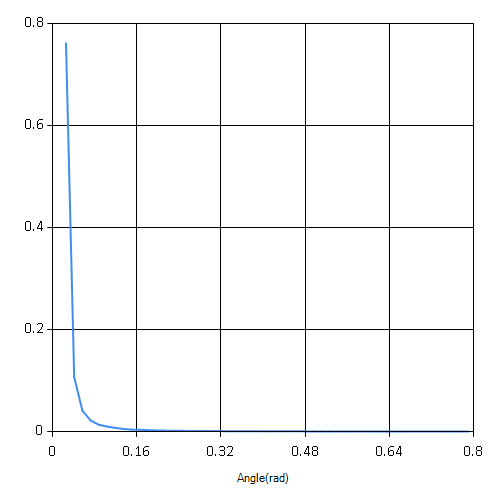

In [7]:
  
let inv_sqr() =
    // Generate a random number based on the 
    // pdf = k/theta^2 with theta € [th_min, pi/2] 
    let k =  0.01006406986 // based on the current thmin = 10^-2
    let thmin= 1e-2
    let r = rnd.NextDouble()
    k*thmin/(k-thmin*r)
let test = [|0..100000|] |> Array.map(fun _ -> inv_sqr())
let htest = hist test 50
Chart.Line(htest)
|> Chart.WithXAxis(Min=0.,Max=0.8, Title="Angle(rad)")
|> Chart.WithSize(500, 500)//|> Display

remember, **Nrays** is the value used to define the number of rays that will be traced.  

Thus, the rays for this configuration are generated as:

In [13]:
let NewRay (pos:Point) (normal:UnitVector) (sigma:float) (rMax:float) =
    let rotpoint = Matrix.RotateVector(UnitVector(0.,0.,1.),normal)
    let rec rfPos() =  // position function
        let orig = Samp2DGauss(sigma,0.) |> fun x -> rotpoint.RotatePoint(Point(x.[0],x.[1],0.))
        if orig.ToVector().Module() > rMax then rfPos()
        else
            orig |> fun px -> px.MoveAndCreateNew(pos) 
    let rPos = rfPos()
    let rvect = // direction
        let theta = inv_sqr()
        let phi = 2.*PI*rnd.NextDouble()
        let stheta = sin(theta)
        UnitVector(cos(phi)*stheta, sin(phi)*stheta, cos(theta))
        |> fun x -> rotpoint.RotateVector(x)
    {
         Wavelenght = wavelength;
         from = rPos; uvec = rvect;
         MaxLength = infi;
         OpticalPathTravelled = 0.<m>;
         NumBounces = 0uy; bounces = [];
         MaxDispersions = 3uy;
         NumOfParticles = 1;
         IndexOfRefraction = 1.
         PhaseModulation = [||]
    }
let ps0 = Point(0.,0.,0.)
let dir0 = UnitVector(1.,0.,0.)

// Function to generate the rays
let ray() = NewRay ps0 dir0 (float(BeamWaist)) (float(Rmirror))

In [14]:
let r = ray()
(r.uvec.X,r.uvec.Y,r.uvec.Z)

(0.999456082, 0.03053657941, 0.0124522086)

In [15]:
[|1..Nrays|] |> Array.Parallel.iter(fun x -> ForwardRay(ray(),objs,mat) ) // ok, look like works

<null>

In [16]:

let path_save1 = @"C:\Users\Jose M. Gonzalez\Desktop\Vibration1_Save_Phase.txt"
SumAndSavePhases (m2.Sensor) (m2.Normal) (path_save1)

<null>

### Analysis of the results
To be able to analize the noise on the output, I have the PostProcess library which producess the noise spectrum of the output.


## Some comments about the PSD and how to compute it:
from [Matlab's manual on signal processing](http://it.mathworks.com/help/signal/ug/psd-estimate-using-fft.html) we can find that:
$$ PSD = \dfrac{1}{f_{sampling}\cdot N} |fft(x)|^2 $$
Where $f_{sampling} means for the maximum sampling frequency which is 2 times the maximum obtained on the fft. Also there's the point that since we only use the positive frequencies, then we multiply the obtained PSD per 2 in order to obtain show all on the positive axis.

Another method to compute the PSD is to use one of the signal analysis functions available on *scipy* which already compute the PSD. One of those methods are [welch](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch) which applies a [window function](https://en.wikipedia.org/wiki/Window_function) and by default has the hanning

In [17]:
let planckConstant, vLight = 6.626070e-34, 299792458. 
let wavelen = (match ray().Wavelenght with WaveLength x -> float x)
let PhotonEnergy = planckConstant*vLight/wavelen
let pp = 0.8e6
m2.Sensor.SavedData
1./(1e-6*pp/PhotonEnergy)

2.333700437e-19

In [ ]:
let phnoise = NoiseInterferometerArm m2 tube mat (ray()) 8e5 // transform the phase into noise
let path_save = @"C:\Users\Jose M. Gonzalez\Desktop\Vibration1_sin_upconversion.txt"
File.WriteAllLines( path_save, phnoise |> Array.map(fun x -> string(x)) );;